## 🎯 Analysis Objective

In this script, we aim to **analyze uncertainty (UQ), absolute error (ABS)**, and their **correlation**, for each patient across two key anatomical regions:

- The **entire slice**
- The **prostate region**

### 🔍 We categorize each patient into the following groups:

#### 🔹 Uncertainty Magnitude
- **Low UQ in Prostate**
- **High UQ in Prostate**
- **Low UQ in Whole Slice**
- **High UQ in Whole Slice**

#### 🔹 Absolute Error Magnitude
- **Low ABS Error in Prostate**
- **High ABS Error in Prostate**
- **Low ABS Error in Whole Slice**
- **High ABS Error in Whole Slice**

#### 🔹 Correlation (Pearson) Between UQ and ABS
- **Low Correlation in Prostate**
- **High Correlation in Prostate**
- **Low Correlation in Whole Slice**
- **High Correlation in Whole Slice**

---

### 🧠 Why are we doing this?

This categorization allows us to:

- Understand how **uncertainty behaves across the cohort**
- Determine if **UQ maps align with actual model error**
- Explore whether **UQ magnitude alone** can predict reconstruction failure or trustworthiness
- Identify cases where UQ is **high but not meaningful** (low correlation), and vice versa

---

### 📈 What do we want to visualize?

We will:

- Plot **histograms** of UQ and ABS values
- Plot **scatter plots** of UQ vs ABS, and UQ vs correlation
- Highlight **outlier patients** (e.g., high UQ but low error or correlation)
- Compare **R=3 vs R=6** to observe acceleration effects

---

### 🧪 Goal

To assess whether patient selection or triage based on **prospective uncertainty maps** is feasible — and scientifically justifiable — in deep learning-based MRI reconstruction.


In [2]:
from pathlib import Path
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

roots = {
    'kspace':            Path('/scratch/p290820/datasets/003_umcg_pst_ksps'),
    'reader_study':      Path('/scratch/hb-pca-rad/projects/03_reader_set_v2'),
    'reader_study_segs': Path('/scratch/hb-pca-rad/projects/03_reader_set_v2/segs'),
    'R3_gaussian':       Path(f"/scratch/hb-pca-rad/projects/04_uncertainty_quantification/gaussian/recons_{3}x"),
    'R6_gaussian':       Path(f"/scratch/hb-pca-rad/projects/04_uncertainty_quantification/gaussian/recons_{6}x"),
    'db_fpath_old':      Path('/scratch/p290820/datasets/003_umcg_pst_ksps/database/dbs/master_habrok_20231106_v2.db'),                  # References an OLDER version of the databases where the info could also just be fine that we are looking for
    'db_fpath_new':      Path('/home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/databases/master_habrok_20231106_v2.db'),    # References the LATEST version of the databases where the info could also just be fine that we are looking for
    'figures_gaussian':  Path('/scratch/hb-pca-rad/projects/04_uncertainty_quantification/gaussian/figures'),
}

tablename = 'slice_level_uq_stats'

📊 Number of patients in the database: 60
📉 Prostate 10th percentile threshold = 0.000782
📉 Whole Slice 10th percentile threshold = 0.000768


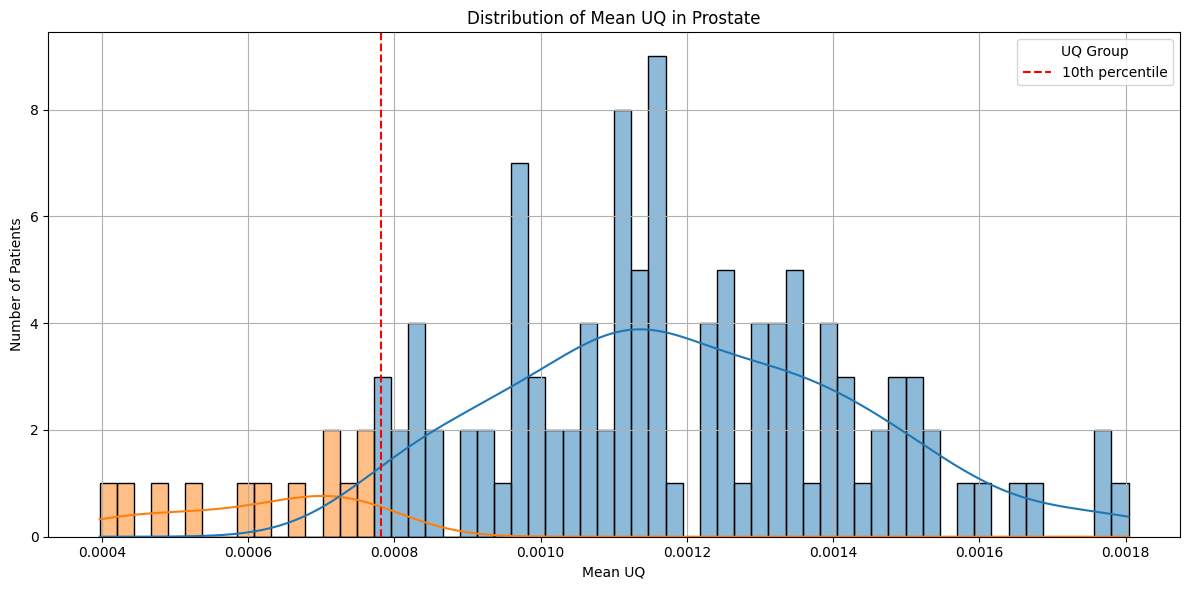

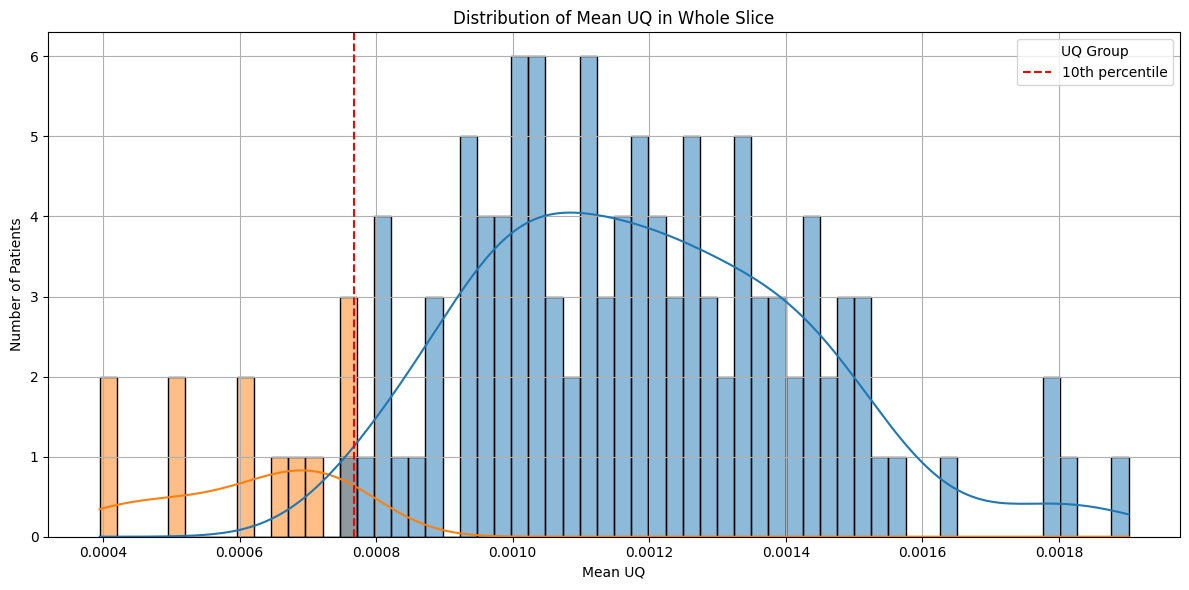

📉 Patients with LOW prostate UQ: 7
	IDs: ['0013_ANON7362087' '0020_ANON1562419' '0032_ANON7649583'
 '0056_ANON2124757' '0058_ANON9719981' '0059_ANON7955208'
 '0075_ANON5895496']
📉 Patients with LOW slice UQ: 6
	IDs: ['0013_ANON7362087' '0032_ANON7649583' '0056_ANON2124757'
 '0058_ANON9719981' '0059_ANON7955208' '0075_ANON5895496']


In [7]:
# --- Helper: Fetch mean UQ by region ---
def get_mean_uq_by_region(region_col: str) -> pd.DataFrame:
    query = f"""
    SELECT
        pat_id,
        acc_factor,
        ROUND(AVG({region_col}), 6) AS mean_uq
    FROM {tablename}
    WHERE
        {region_col} IS NOT NULL
    GROUP BY pat_id, acc_factor
    """
    return pd.read_sql_query(query, conn)


# --- Helper: Label LOW vs NORMAL/HIGH based on percentile ---
def label_uq_group(df: pd.DataFrame, value_col: str, label_col: str) -> float:
    threshold = df[value_col].quantile(percentile_cutoff / 100)
    df[label_col] = df[value_col].apply(lambda x: "LOW" if x < threshold else "NORMAL/HIGH")
    return threshold


# --- Plotting Function ---
def plot_uq_distribution(df: pd.DataFrame, title: str, threshold: float):
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df, x="mean_uq", hue="uq_group", bins=60, kde=True)
    plt.axvline(threshold, color="red", linestyle="--", label=f"{percentile_cutoff}th percentile")
    plt.title(title)
    plt.xlabel("Mean UQ")
    plt.ylabel("Number of Patients")
    plt.legend(title="UQ Group")
    plt.grid()
    plt.tight_layout()
    plt.show()


# --- Configuration ---
percentile_cutoff = 10  # bottom 10%
tablename = "slice_level_uq_stats"

# --- Connect to DB ---
conn = sqlite3.connect(roots['db_fpath_new'])

# --- Check first how many patients we have in the database, that will be the result of the next query ---
query = f"""
SELECT
    pat_id,
    acc_factor,
    ROUND(AVG(mean_uq_prostate), 6) AS mean_uq_prostate,
    ROUND(AVG(mean_uq_slice), 6) AS mean_uq_slice
FROM {tablename}
WHERE
    mean_uq_prostate IS NOT NULL
    AND
    acc_factor = 3
GROUP BY pat_id, acc_factor
"""
df_patients = pd.read_sql_query(query, conn)
print(f"📊 Number of patients in the database: {len(df_patients)}")

# --- Prostate Analysis ---
df_prostate = get_mean_uq_by_region("mean_uq_prostate")
prostate_thresh = label_uq_group(df_prostate, "mean_uq", "uq_group")
print(f"📉 Prostate {percentile_cutoff}th percentile threshold = {prostate_thresh:.6f}")

# --- Slice Analysis ---
df_slice = get_mean_uq_by_region("mean_uq_slice")
slice_thresh = label_uq_group(df_slice, "mean_uq", "uq_group")
print(f"📉 Whole Slice {percentile_cutoff}th percentile threshold = {slice_thresh:.6f}")

# --- Plot ---
plot_uq_distribution(df_prostate, "Distribution of Mean UQ in Prostate", prostate_thresh)
plot_uq_distribution(df_slice, "Distribution of Mean UQ in Whole Slice", slice_thresh)

# --- Get pad_ids of patients with LOW UQ ---
low_patients_prostate = df_prostate[df_prostate["uq_group"] == "LOW"]["pat_id"].unique()
low_patients_slice = df_slice[df_slice["uq_group"] == "LOW"]["pat_id"].unique()
print(f"📉 Patients with LOW prostate UQ: {len(low_patients_prostate)}")
print(f"\tIDs: {low_patients_prostate}")
print(f"📉 Patients with LOW slice UQ: {len(low_patients_slice)}")
print(f"\tIDs: {low_patients_slice}")

# --- Done ---
conn.close()


In [ ]:
# lets load in the absolute error map and the UQ map and make a histogram of both. But why?

r3_error = np.load(roots['R3_gaussian'] / 'absolute_error_map.npy')